![alt text](./Cerny_logo_1.jpg)

# Analysis of Cerny ventilation recordings

#### Further processing and analysis of ventilator parameters 

This notebook import the preprocessed ventilator data from piclkle archive and analyses all the ventilator parameter data and alarms data obtained with **0.5Hz sampling rate** from the Fabian ventilators at the Cerny neonatal transport service. It exports desrciptive statistics into Excel files and the further processed data as pickle archive.

The data processed and analysed in this Notebook were collected by the **Neonatal Emergency and Transport Service of the Peter Cerny Foundation**, Budapest, Hungary

**Author: Dr Gusztav Belteki**

### 1. Import the required libraries and set options

In [1]:
import IPython
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

import os
import sys
import pickle

from pandas import Series, DataFrame
from datetime import datetime, timedelta
from matplotlib import dates

%matplotlib inline
matplotlib.style.use('classic')
matplotlib.rcParams['figure.facecolor'] = 'w'

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 300)
pd.set_option('mode.chained_assignment', None) 

# This is to turn off a warning message which is given when read_Excel() imports '.xlsx' files
import warnings
warnings.simplefilter("ignore")

In [2]:
print("Python version: {}".format(sys.version))
print("pandas version: {}".format(pd.__version__))
print("matplotlib version: {}".format(matplotlib.__version__))
print("NumPy version: {}".format(np.__version__))
print("IPython version: {}".format(IPython.__version__))

Python version: 3.11.7 (main, Dec 15 2023, 12:09:04) [Clang 14.0.6 ]
pandas version: 2.1.4
matplotlib version: 3.8.0
NumPy version: 1.26.3
IPython version: 8.20.0


### 2. List and set the working directory and the directory to write out data

In [3]:
# Name of the external hard drive
DRIVE = 'GUSZTI'

# Directory on external drive to read the clinical from
DIR_READ = os.path.join(os.sep, 'Volumes', DRIVE, 'Fabian_new', 'fabian_patient_data_all_new')

# Path to project folder containing ventilation research results
PATH = os.path.join(os.sep, 'Users', 'guszti', 'Library', 'Mobile Documents', 'com~apple~CloudDocs', 
                            'Documents', 'Research', 'Ventilation')

# Folder to export the result of analysis
DIR_WRITE = os.path.join(PATH, 'ventilation_fabian_new', 'Analyses')
os.makedirs(DIR_WRITE, exist_ok = True)

# Folder on a USB stick to export data to and to import processed data exported by other Notebooks
DATA_DUMP = os.path.join(os.sep, '/Volumes', DRIVE, 'data_dump', 'fabian_new',)
os.makedirs(DATA_DUMP, exist_ok = True)

In [4]:
DIR_READ, DIR_WRITE, DATA_DUMP

('/Volumes/GUSZTI/Fabian_new/fabian_patient_data_all_new',
 '/Users/guszti/Library/Mobile Documents/com~apple~CloudDocs/Documents/Research/Ventilation/ventilation_fabian_new/Analyses',
 '/Volumes/GUSZTI/data_dump/fabian_new')

### 3. Import pickle archives

In [5]:
%%time

with open(os.path.join(DATA_DUMP, 'data_pars_1_150.pickle'), 'rb') as handle:
    data_pars_1_150 = pickle.load(handle)

with open(os.path.join(DATA_DUMP, 'data_pars_151_300.pickle'), 'rb') as handle:
    data_pars_151_300 = pickle.load(handle)

with open(os.path.join(DATA_DUMP, 'data_pars_301_450.pickle'), 'rb') as handle:
    data_pars_301_450 = pickle.load(handle)
    
with open(os.path.join(DATA_DUMP, 'data_pars_451_600.pickle'), 'rb') as handle:
    data_pars_451_600 = pickle.load(handle)
    
with open(os.path.join(DATA_DUMP, 'data_pars_601_750.pickle'), 'rb') as handle:
    data_pars_601_750 = pickle.load(handle)
    
with open(os.path.join(DATA_DUMP, 'data_pars_751_900.pickle'), 'rb') as handle:
    data_pars_751_900 = pickle.load(handle)
    
with open(os.path.join(DATA_DUMP, 'data_pars_901_1050.pickle'), 'rb') as handle:
    data_pars_901_1050 = pickle.load(handle)
    
with open(os.path.join(DATA_DUMP, 'data_pars_1051_1200.pickle'), 'rb') as handle:
    data_pars_1051_1200 = pickle.load(handle)

with open(os.path.join(DATA_DUMP, 'data_pars_1201_1350.pickle'), 'rb') as handle:
    data_pars_1201_1350 = pickle.load(handle)
    
data_pars = {**data_pars_1_150, **data_pars_151_300, **data_pars_301_450, **data_pars_451_600,
             **data_pars_601_750, **data_pars_751_900, **data_pars_901_1050, **data_pars_1051_1200,
            **data_pars_1201_1350,}

CPU times: user 7.13 s, sys: 1.71 s, total: 8.84 s
Wall time: 14.2 s


In [6]:
# Total number of ventilator recordings longer than 15 minutes
len(data_pars)

1076

In [7]:
# Clinical data
with open(os.path.join(DATA_DUMP, 'clin_df_new.pickle'), 'rb') as handle:
    clin_df = pickle.load(handle)

In [8]:
# Number of cases where clinical data are available
len(clin_df)

1015

#### Limit ventilator data to cases for which clinical data and appropriate (>15 minutes) ventilator data are available

In [9]:
combined = sorted(set(clin_df.index) & set(data_pars.keys()))
data_pars = {key : value for key, value in data_pars.items() if key in combined}
len(data_pars)

1015

### 4. Create a dictionary of Dataframes with measured ventilator parameters only

In [10]:
ventilator_measurements = ['PIP', 'MAP', 'PEEP', 'Ti_PSV', 'Cdyn', 'C20_C', 'R', 
                           'MV', 'MVresp', 'VTemand', 'VTemand_resp', 'VTespon_pat', 
                           'Leak', 'RR', 'Trigger', 'VTimand', 'deltaP', 'VThf_emand', 
                           'DCO2', 'HFOV_freq', 'FiO2', 'etCO2', 'Flow_demand', 
                           'Flow_insp', 'Flow_exp', 'TC', 'RR_CO2', 
                           'SpO2', 'Perfusion_index', 'Pulse_rate', 'PVI', 'RSBI', 'FiCO2', 'VTe_kg',]

In [11]:
ventilator_measurements = ['PIP', 'MAP', 'PEEP', 'Ti_PSV', 'Cdyn', 'C20_C', 'R', 
                           'MV', 'MVresp', 'VTemand', 'VTemand_resp', 'VTespon_pat', 
                           'Leak', 'RR', 'Trigger', 'VTimand', 'deltaP', 'VThf_emand', 
                           'DCO2', 'HFOV_freq', 'FiO2', 'etCO2', 'Flow_demand', 
                           'Flow_insp', 'Flow_exp', 'TC', 'RR_CO2', 
                           'SpO2', 'Perfusion_index', 'Pulse_rate',]

In [12]:
data_pars_measurements = {}
for case in data_pars:
    data_pars_measurements[case] = data_pars[case][ventilator_measurements].copy()

In [13]:
%%time

# Replace some uninformative fields with np.nan
repl_dct = {'not valid': np.nan, 'out of range': np.nan, 'unused': np.nan}
for case in data_pars_measurements:
    data_pars_measurements[case].replace(repl_dct, inplace = True)

CPU times: user 7.98 s, sys: 128 ms, total: 8.11 s
Wall time: 8.16 s


In [14]:
# Normalize relevant parameters to body weight
pars_per_kg = ['MV', 'VTimand', 'VTemand', 'VTespon_pat', 'VTemand_resp', 'VThf_emand', 'Cdyn']

for case in data_pars_measurements:
    for par in pars_per_kg:
        data_pars_measurements[case]['%s_kg' % par] = \
        data_pars_measurements[case][par] / (clin_df.loc[case]['Weight'] / 1000)

In [15]:
# Normalize DCO2 to body weight
pars_per_kg2 = ['DCO2']

for case in data_pars_measurements:
    for par in pars_per_kg2:
        data_pars_measurements[case]['%s_kg2' % par] = \
        data_pars_measurements[case][par] / (clin_df.loc[case]['Weight'] / 1000) ** 2

In [16]:
# Drop columns which only have NaN values
for case in data_pars_measurements:
    data_pars_measurements[case].dropna(axis = 1, how = 'all', inplace = True)

#### Export dictionary containing measured ventilator parameters to a pickle archive

In [17]:
with open(os.path.join(DATA_DUMP, 'data_pars_measurements_new_1_1305.pickle'), 'wb') as handle:
    pickle.dump(data_pars_measurements, handle, protocol=pickle.HIGHEST_PROTOCOL)

### 5. Create a dictionary of Dataframes with ventilator settings

There are two `Trigger_mode` parameters. After manual observation of the data and discussion with the clinical team, `Trigger_mode_2` contains the actual ventilator triggering mode

In [20]:
ventilator_settings = ['Patient_range', 'Ventilator_mode', 'PIP_set', 'PIP_set_PSV', 
    'PEEP_set', 'FiO2_set', 'Flow_insp_set', 'Slope_set', 'Flow_exp_set', 'Ti_set', 
    'Te_set', 'RR_set', 'IE_I_set', 'IE_E_set', 'deltaP_set', 'Freq_set_HFOV', 
    'MAP_set_HFOV', 'MAP_set_HFOV_recr', 'Volume_limit_set', 'VG_set',
    'Term_criteria_PSV_set', 'Apnea_time_set', 'RR_backup_set', 'Trigger_sens_set', 
    'Powerstate', 'Battery_rem_time', 'Battery_rem_pc', 'MV_lim_high_set', 
    'MV_lim_low_set', 'PIP_lim_high_set', 'PEEP_lim_low_set', 'RR_lim_set', 
    'Leakage_lim_set', 'DCO2_lim_high_set', 'DCO2_lim_low_set', 'etCO2_lim_high_set', 
    'etCO2_lim_low_set', 'Measuring_unit_pressure_set', 'Measuring_unit_CO2_set', 
    'O2_compensation_set', 'CO2_baropressure_set',
    'Flow_sensor_state', 'Oxy_sensor_state', 'P_man_breath_CPAP_HFO_set', 
    'P_man_breath_duoPAP_NCPAP_set', 'FiO2_flush_time_set', 'FiO2_flush_set',
    'Ventilation_stopped', 'VG_state', 'Volume_limit_state', 'Ventilator_range',
    'Trigger_mode', 'I_E_HFOV', 'Pressure_rise_control',
    'HFO_recruitment', 'HFO_flow', 'Bias_flow', 'Trigger_mode_2', 'FOT_running', 'Leak_comp']    

In [21]:
data_pars_settings = {}

for case in data_pars:
    data_pars_settings[case] = data_pars[case][ventilator_settings].copy()

In [22]:
# Replace textual data with np.nan
repl_dct = {'not valid': np.nan, 'out of range': np.nan, 'unused': np.nan}
for case in data_pars_settings:
    data_pars_settings[case].replace(repl_dct, inplace = True)

In [23]:
# Normalize relevant parameters to body weight
pars_per_kg = ['Volume_limit_set', 'VG_set', 'MV_lim_high_set', 'MV_lim_low_set',]

for case in data_pars_settings:
    #print(case)
    for par in pars_per_kg:
        dta = data_pars_settings[case][par]
        # Exclude data points when the parameter was 'off'
        data_pars_settings[case]['%s_kg' % par] = \
        dta[dta != 'off'] / (clin_df.loc[case]['Weight'] / 1000)

In [24]:
# Normalize DCO2 limits parameters to body weight square
pars_per_kg = ['DCO2_lim_high_set', 'DCO2_lim_low_set']

for case in data_pars_settings:
    for par in pars_per_kg:
        dta = data_pars_settings[case][par]
        # Exclude data points when the parameter was 'off'
        data_pars_settings[case]['%s_kg2' % par] = \
        dta[dta != 'off'] / (clin_df.loc[case]['Weight'] / 1000) ** 2

In [25]:
# Drop columns which only have NaN values
for case in data_pars_settings:
    data_pars_settings[case].dropna(axis=1, how='all', inplace = True)

#### Export dictionary containing ventilator settings to a pickle archive

In [26]:
with open(os.path.join(DATA_DUMP, 'data_pars_settings_new_1_1305.pickle'), 'wb') as handle:
    pickle.dump(data_pars_settings, handle, protocol=pickle.HIGHEST_PROTOCOL)

### 6. Create a dictionary of Dataframes with ventilator alarms

In [27]:
ventilator_alarms = ['Alarm_susp', 'Alarm_Flat_battery', 'Alarm_Checksum_ctrl_PIC',
                     'Alarm_Checksum_monitor_PIC', 'Alarm_Safety_relay_defect',
                     'Alarm_Sens_dev_prox_pressure', 'Alarm_input_pressure_blender',
                     'Alarm_excess_pressure', 'Alarm_voltage_monit',
                     'Alarm_SPI_interface', 'Alarm_DIO2_interface',
                     'Alarm_COM_interface', 'Alarm_I2C_interface',
                     'Alarm_parallel_interface', 'Alarm_serial_tem_interface',
                     'Alarm_low_physical_memory', 'Alarm_Fan_defect',
                     'Alarm_CO2_interface', 'Alarm_blender_defect',
                     'Alarm_battery_defect', 'Alarm_input_pressure_O2_supply',
                     'Alarm_input_pressure_air_supply', 'Alarm_tube_occlusion',
                     'Alarm_patient_disconnected', 'Alarm_ETT_blocked',
                     'Alarm_flow_sensor_defect', 'Alarm_flow_sensor_clean',
                     'Alarm_flow_sensor_disconnected', 'Oxygen_sensor_defect',
                     'Oxygen_sensor_used_up', 'Oxyen_value_divergence',
                     'Alarm_O2_sensor_cal_error', 'Alarm_MV_high', 'Alarm_MV_low',
                     'Alarm_pressure_high', 'Alarm_pressure_low', 'Alarm_PEEP_high',
                     'Alarm_RR_high', 'Alarm_ETT_leak_high', 'Alarm_apnea',
                     'Alarm_DCO2_high', 'Alarm_DCO2_low', 'Alarm_etCO2_high',
                     'Alarm_etCO2_low', 'Alarm_PIP_not_reached', 'Alarm_limited_volume',
                     'Alarm_volume_not_reached', 'Alarm_power_failure',
                     'Alarm_charge_battery_60min', 'Alarm_charge_battery_30min',
                     'Alarm_charge_battery_15min', 'Alarm_nebulizer_disconnection',
                     'Alarm_nebulizer_system_error', 'Alarm_CO2_module_not_connected',
                     'Alarm_CO2_filterline_not_connected', 'Alarm_CO2_check_sampleline',
                     'Alarm_CO2_check_airway_adapter', 'Alarm_CO2_sensor_faulty',
                     'Alarm_CO2_high', 'Alarm_CO2_low', 'Alarm_PRICO_FiO2_our_of_range',
                     'Alarm_SPO2_module_not_connected', 'Alarm_SPO2_sensor_faulty',
                     'Alarm_check_SPO2_sensor', 'Alarm_SPO2_low_SIQ', 'Alarm_high_SPO2',
                     'Alarm_low_SPO2', 'Alarm_SPO2_low_PI', 'Alarm_low_PIP',
                     'Alarm_high_FICO2', 'Alarm_low_FICO2', 'Alarm_high_pulserate',
                     'Alarm_low_pulserate']

In [28]:
ventilator_alarms = ['Alarm_susp', 'Alarm_Flat_battery', 'Alarm_Checksum_ctrl_PIC',
                     'Alarm_Checksum_monitor_PIC', 'Alarm_Safety_relay_defect',
                     'Alarm_Sens_dev_prox_pressure', 'Alarm_input_pressure_blender',
                     'Alarm_excess_pressure', 'Alarm_voltage_monit',
                     'Alarm_SPI_interface', 'Alarm_DIO2_interface',
                     'Alarm_COM_interface', 'Alarm_I2C_interface',
                     'Alarm_parallel_interface', 'Alarm_serial_tem_interface',
                     'Alarm_low_physical_memory', 'Alarm_Fan_defect',
                     'Alarm_CO2_interface', 'Alarm_blender_defect',
                     'Alarm_battery_defect', 'Alarm_input_pressure_O2_supply',
                     'Alarm_input_pressure_air_supply', 'Alarm_tube_occlusion',
                     'Alarm_patient_disconnected', 'Alarm_ETT_blocked',
                     'Alarm_flow_sensor_defect', 'Alarm_flow_sensor_clean',
                     'Alarm_flow_sensor_disconnected', 'Oxygen_sensor_defect',
                     'Oxygen_sensor_used_up', 'Oxyen_value_divergence',
                     'Alarm_O2_sensor_cal_error', 'Alarm_MV_high', 'Alarm_MV_low',
                     'Alarm_pressure_high', 'Alarm_pressure_low', 'Alarm_PEEP_high',
                     'Alarm_RR_high', 'Alarm_ETT_leak_high', 'Alarm_apnea',
                     'Alarm_DCO2_high', 'Alarm_DCO2_low', 'Alarm_etCO2_high',
                     'Alarm_etCO2_low', 'Alarm_PIP_not_reached', 'Alarm_limited_volume',
                     'Alarm_volume_not_reached', 'Alarm_power_failure',
                     'Alarm_charge_battery_60min', 'Alarm_charge_battery_30min',
                     'Alarm_charge_battery_15min', 'Alarm_nebulizer_disconnection',
                     'Alarm_nebulizer_system_error', 'Alarm_CO2_module_not_connected',
                     'Alarm_CO2_filterline_not_connected', 'Alarm_CO2_check_sampleline',
                     'Alarm_CO2_check_airway_adapter', 'Alarm_CO2_sensor_faulty',
                     'Alarm_CO2_high', 'Alarm_CO2_low', 'Alarm_PRICO_FiO2_our_of_range',
                     'Alarm_SPO2_module_not_connected', 'Alarm_SPO2_sensor_faulty',
                     'Alarm_check_SPO2_sensor', 'Alarm_SPO2_low_SIQ', 'Alarm_high_SPO2',
                     'Alarm_low_SPO2', 'Alarm_SPO2_low_PI', 'Alarm_low_PIP',]

In [29]:
data_pars_alarms = {}

for case in data_pars:
    data_pars_alarms[case] = data_pars[case][ventilator_alarms].copy()

In [30]:
# Replace textual data with np.nan
repl_dct = {'off': np.nan, 'not valid': np.nan, 'out of range': np.nan, 'unused': np.nan}
for case in data_pars_alarms:
    data_pars_alarms[case].replace(repl_dct, inplace = True)

In [31]:
%%time

# Drop columns which only have NaN values (these alarms never went off)
for case in data_pars_alarms:
    for column in data_pars_alarms[case].columns:
        if data_pars_alarms[case][column].sum() == 0:
            del data_pars_alarms[case][column]        

CPU times: user 16.3 s, sys: 182 ms, total: 16.4 s
Wall time: 16.5 s


#### Export dictionary containing ventilator alarms to a pickle archive

In [32]:
with open(os.path.join(DATA_DUMP, 'data_pars_alarms_new_1_1305.pickle'), 'wb') as handle:
    pickle.dump(data_pars_alarms, handle, protocol=pickle.HIGHEST_PROTOCOL)

### 7. Exploratory analysis on ventilation modes in the unedited recordings

##### How many cases of the different ventilation modes occur

In [33]:
vent_modes = {}
for case in data_pars_settings:
    # Multiply by two to get the number of seconds
    vent_modes[case] = data_pars_settings[case]['Ventilator_mode'].value_counts() * 2
    
vent_modes = DataFrame(vent_modes).T
vent_modes.replace(np.nan, 0, inplace = True)

In [34]:
# Add the duration of the recordings

recording_duration = {}

for case in data_pars_settings:
    recording_duration[case] = 2 * len(data_pars_settings[case])

In [35]:
vent_modes['ventilation'] = vent_modes['IPPV']  + vent_modes['SIMV'] + \
                            vent_modes['PSV']   + vent_modes['HFO'] + \
                            vent_modes['SIPPV'] + vent_modes['SIMVPSV']

vent_modes['noninvasive'] = vent_modes['CPAP']  + vent_modes['DUOPAP'] + \
                            vent_modes['NCPAP'] + vent_modes['O2therapy']  

vent_modes['total'] = Series(recording_duration)

In [36]:
# How long was VG turned on
VG = {}
for case in data_pars_settings:
    VG[case] = sum(data_pars_settings[case]['VG_state'] == 'on') * 2
        
VG = Series(VG)
vent_modes['VG'] = VG

In [37]:
vent_modes.head()

Ventilator_mode,CPAP,DUOPAP,HFO,IPPV,NCPAP,O2therapy,PSV,SIMV,SIMVPSV,SIPPV,ventilation,noninvasive,total,VG
AT000005,0.0,0.0,0.0,0.0,0.0,0.0,0.0,28.0,0.0,4564.0,4592.0,0.0,4592,4538
AT000006,0.0,0.0,0.0,0.0,0.0,2492.0,0.0,0.0,0.0,0.0,0.0,2492.0,2492,0
AT000007,0.0,0.0,0.0,0.0,4800.0,0.0,0.0,0.0,0.0,0.0,0.0,4800.0,4800,0
AT000008,0.0,0.0,0.0,0.0,214.0,0.0,0.0,5376.0,0.0,0.0,5376.0,214.0,5590,3724
AT000009,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1224.0,0.0,4736.0,5960.0,0.0,5960,5244


In [38]:
print('SIMV:', sum(vent_modes['SIMV'] > 0))
print('SIPPV:', sum(vent_modes['SIPPV'] > 0))
print('SIMVPSV:', sum(vent_modes['SIMVPSV'] > 0))
print('PSV:', sum(vent_modes['PSV'] > 0))
print('HFO:', sum(vent_modes['HFO'] > 0))
print('IPPV:', sum(vent_modes['IPPV'] > 0))
print('NCPAP:', sum(vent_modes['NCPAP'] > 0))
print('CPAP:', sum(vent_modes['CPAP'] > 0))
print('DUOPAP:', sum(vent_modes['DUOPAP'] > 0))
print('O2therapy:', sum(vent_modes['O2therapy'] > 0))
print('ventilation:', sum(vent_modes['ventilation'] > 0))
print('VG on:', sum(vent_modes['VG'] > 0))
print('noninvasive:', sum(vent_modes['noninvasive'] > 0))
print('total:', len(vent_modes))

SIMV: 396
SIPPV: 341
SIMVPSV: 135
PSV: 13
HFO: 122
IPPV: 26
NCPAP: 607
CPAP: 44
DUOPAP: 152
O2therapy: 164
ventilation: 697
VG on: 419
noninvasive: 791
total: 1015


In [39]:
# How many seconds of each ventilation mode in total ?
total_duration = DataFrame(vent_modes.sum(axis = 0), columns = ['duration (seconds)'])
total_duration

,duration (seconds)
Ventilator_mode,
CPAP,11798.0
DUOPAP,277048.0
HFO,233012.0
IPPV,15848.0
NCPAP,1419972.0
O2therapy,314420.0
PSV,14034.0
SIMV,964668.0
SIMVPSV,255944.0


##### Export Dataframes containing ventilator modes to Excel files and pickle archives

In [40]:
writer = pd.ExcelWriter(os.path.join(DIR_WRITE, 'ventilation_modes_unedited_new_1_1305.xlsx'))
vent_modes.to_excel(writer, 'vent_modes')
total_duration.to_excel(writer, 'total_duration')
writer.close()

In [42]:
with open(os.path.join(DATA_DUMP, 'vent_modes_unedited_new_1_1305.pickle'), 'wb') as handle:
    pickle.dump(vent_modes, handle, protocol=pickle.HIGHEST_PROTOCOL)

##### Export data about ventilation modes in the unedited recordings as text files

In [43]:
for case in data_pars_settings:
    a = data_pars_settings[case]
    
    o2therapy = len(a[a['Ventilator_mode'] == 'O2therapy'])
    ncpap = len(a[a['Ventilator_mode'] == 'NCPAP'])
    duopap = len(a[a['Ventilator_mode'] == 'DUOPAP'])
    simv = len(a[a['Ventilator_mode'] == 'SIMV'])
    ippv = len(a[a['Ventilator_mode'] == 'IPPV'])
    sippv = len(a[a['Ventilator_mode'] == 'SIPPV'])
    simvpsv = len(a[a['Ventilator_mode'] == 'SIMVPSV'])
    hfo = len(a[a['Ventilator_mode'] == 'HFO'])
    vg_on = len(data_pars[case][data_pars[case]['VG_state'] == 'on'])
  
    
    fileout = open(os.path.join(DATA_DUMP, 'fabian_cases_new', case, f'{case}_vent_info_unedited.txt'), 'w')
    
    # Sampling is 0.5 Hz, hence multiply it by 2 to get the number of seconds
    fileout.write('O2 therapy: %d sec \n' % (o2therapy * 2))
    fileout.write('NCPAP:      %d sec \n' % (ncpap * 2))
    fileout.write('DUOPAP:     %d sec \n' % (duopap * 2))
    fileout.write('IPPV:       %d sec \n' % (ippv * 2))
    fileout.write('SIPPV:      %d sec \n' % (sippv * 2))
    fileout.write('SIMV:       %d sec \n' % (simv * 2))
    fileout.write('SIMVPSV:    %d sec \n' % (simvpsv * 2))
    fileout.write('HFO:        %d sec \n\n' % (hfo * 2))
    fileout.write('VG on:      %d sec \n' % (vg_on * 2))
    
    fileout.close()

### 8. Make some graphs about all recordings in an unedited way

In [44]:
majorFmt = dates.DateFormatter('%H:%M')
filetype = 'jpg'
dpi = 200

Saving AT000005
Saving AT000006
AT000006 does not have ventilation
'MV_kg'
Saving AT000007
AT000007 does not have ventilation
'MV_kg'
Saving AT000008
Saving AT000009
Saving AT000011
AT000011 does not have ventilation
'MV_kg'
Saving AT000012
AT000012 does not have ventilation
'MV_kg'
Saving AT000013
AT000013 does not have ventilation
'MV_kg'
Saving AT000014
AT000014 does not have ventilation
'MV_kg'
Saving AT000015
AT000015 does not have ventilation
'MV_kg'
Saving AT000016
AT000016 does not have ventilation
'MV_kg'
Saving AT000017
Saving AT000018
Saving AT000019
AT000019 does not have ventilation
'MV_kg'
Saving AT000020
AT000020 does not have ventilation
'MV_kg'
Saving AT000022
Saving AT000023
Saving AT000025
AT000025 does not have ventilation
'MV_kg'
Saving AT000027
AT000027 does not have ventilation
'MV_kg'
Saving AT000029
Saving AT000030
Saving AT000031
Saving AT000032
AT000032 does not have ventilation
'MV_kg'
Saving AT000033
Saving AT000034
Saving AT000035
Saving AT000036
AT000036 

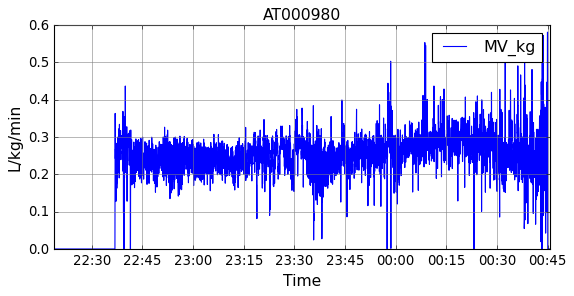

In [45]:
%%time

par = 'MV_kg'
dim = 'L/kg/min'; 
for case in data_pars_measurements:
    
    #if int(case[2:].lstrip('0')) <= 1179:
    #    continue

    try:
        print('Saving %s' % case)
        fig = plt.figure()
        fig.set_size_inches(8, 4)
        fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.1)
        ax = fig.add_subplot(1, 1, 1)
        data_pars_measurements[case][par].plot(ax = ax, label = par, x_compat = True)
        ax.set_xlabel('Time', size = 14, color = 'black')
        ax.set_ylabel(dim, size = 14, color = 'black')
        ax.set_title(case,  size = 14, color = 'black')
        ax.legend()
        ax.grid('on', linestyle='-', linewidth=0.5, color = 'gray')
        ax.xaxis.set_major_formatter(majorFmt)
        plt.setp(ax.xaxis.get_majorticklabels(), rotation=0, fontsize = 12, horizontalalignment = 'center')
        ax.tick_params(which = 'both', labelsize=12)
            
        fig.savefig(os.path.join(DATA_DUMP, 'fabian_cases_new', case, f'{case}_unedited_{par}.{filetype}'), 
            dpi = dpi, format = filetype, bbox_inches='tight', pad_inches=0.1,);

        if case != 'AT000980':
            plt.close()
        
    except Exception as e:
        print('%s does not have ventilation' % case)
        print(e)
        plt.close()
        


Saving AT000005
Saving AT000006
Saving AT000007
Saving AT000008
Saving AT000009
Saving AT000011
Saving AT000012
Saving AT000013
Saving AT000014
Saving AT000015
Saving AT000016
Saving AT000017
Saving AT000018
Saving AT000019
Saving AT000020
Saving AT000022
Saving AT000023
Saving AT000025
Saving AT000027
Saving AT000029
Saving AT000030
Saving AT000031
Saving AT000032
Saving AT000033
Saving AT000034
Saving AT000035
Saving AT000036
Saving AT000037
Saving AT000038
Saving AT000039
Saving AT000040
Saving AT000042
Saving AT000043
Saving AT000048
Saving AT000049
Saving AT000050
Saving AT000051
Saving AT000052
Saving AT000053
Saving AT000054
Saving AT000055
Saving AT000056
Saving AT000057
Saving AT000058
Saving AT000059
Saving AT000060
Saving AT000061
Saving AT000062
Saving AT000063
Saving AT000065
Saving AT000066
Saving AT000068
Saving AT000069
Saving AT000070
Saving AT000072
Saving AT000073
Saving AT000074
Saving AT000075
Saving AT000076
Saving AT000077
Saving AT000078
Saving AT000079
Saving A

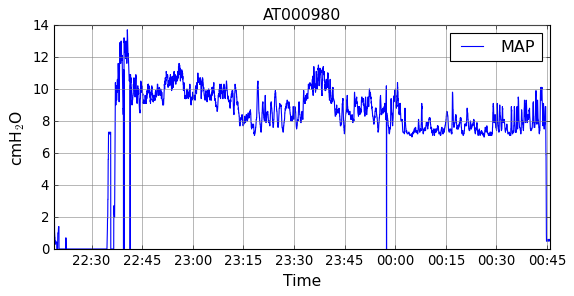

In [49]:
%%time

par = 'MAP'
dim = 'cmH$_2$O'; filetype = 'jpg'; dpi = 200

for case in data_pars_measurements:
    
    #if int(case[2:].lstrip('0')) <= 1180:
    #    continue
    
    try:
        print('Saving %s' % case)
        fig = plt.figure()
        fig.set_size_inches(8, 4)
        fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.1)
        ax = fig.add_subplot(1, 1, 1)
        data_pars_measurements[case][par].plot(ax = ax, label = par, x_compat = True)
        ax.set_xlabel('Time', size = 14, color = 'black')
        ax.set_ylabel(dim, size = 14, color = 'black')
        ax.set_title(case,  size = 14, color = 'black')
        ax.legend()
        ax.grid('on', linestyle='-', linewidth=0.5, color = 'gray')
    
        majorFmt = dates.DateFormatter('%H:%M')  
        ax.xaxis.set_major_formatter(majorFmt)
        plt.setp(ax.xaxis.get_majorticklabels(), rotation=0, fontsize = 12, horizontalalignment = 'center')
        ax.tick_params(which = 'both', labelsize=12)
            
        fig.savefig(os.path.join(DATA_DUMP, 'fabian_cases_new', case, f'{case}_unedited_{par}.{filetype}'), 
            dpi = dpi, format = filetype, bbox_inches='tight', pad_inches=0.1,);

        if case != 'AT000980':
            plt.close()
            
    except Exception as e:
        print('%s does not have MAP' % case)
        print(e)
        plt.close()

In [50]:
mapping_vent_mode = {1: 'IPPV', 2: 'SIPPV', 3: 'SIMV', 4: 'SIMVPSV', 5: 'PSV', 
                     6: 'CPAP', 7: 'NCPAP', 8: 'DUOPAP', 9: 'HFO', 10: 'O2therapy'}
mapping_vent_mode_rev = {value:key for key, value in mapping_vent_mode.items()}
mapping_vent_mode_rev

{'IPPV': 1,
 'SIPPV': 2,
 'SIMV': 3,
 'SIMVPSV': 4,
 'PSV': 5,
 'CPAP': 6,
 'NCPAP': 7,
 'DUOPAP': 8,
 'HFO': 9,
 'O2therapy': 10}

In [51]:
mapping_VG = {11: 'off', 12: 'on'}
mapping_VG_rev = {value:key for key, value in mapping_VG.items()}
mapping_VG_rev

{'off': 11, 'on': 12}

Saving AT000005
Saving AT000006
Saving AT000007
Saving AT000008
Saving AT000009
Saving AT000011
Saving AT000012
Saving AT000013
Saving AT000014
Saving AT000015
Saving AT000016
Saving AT000017
Saving AT000018
Saving AT000019
Saving AT000020
Saving AT000022
Saving AT000023
Saving AT000025
Saving AT000027
Saving AT000029
Saving AT000030
Saving AT000031
Saving AT000032
Saving AT000033
Saving AT000034
Saving AT000035
Saving AT000036
Saving AT000037
Saving AT000038
Saving AT000039
Saving AT000040
Saving AT000042
Saving AT000043
Saving AT000048
Saving AT000049
Saving AT000050
Saving AT000051
Saving AT000052
Saving AT000053
Saving AT000054
Saving AT000055
Saving AT000056
Saving AT000057
Saving AT000058
Saving AT000059
Saving AT000060
Saving AT000061
Saving AT000062
Saving AT000063
Saving AT000065
Saving AT000066
Saving AT000068
Saving AT000069
Saving AT000070
Saving AT000072
Saving AT000073
Saving AT000074
Saving AT000075
Saving AT000076
Saving AT000077
Saving AT000078
Saving AT000079
Saving A

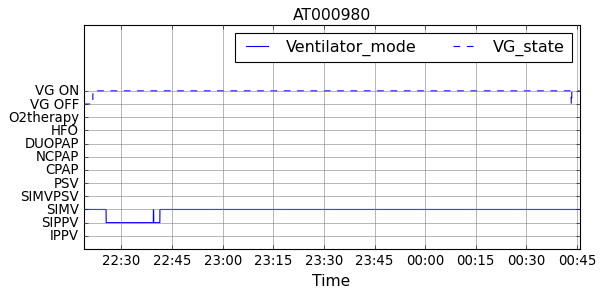

In [52]:
%%time

par1 = 'Ventilator_mode'
par2 = 'VG_state'
dim = 'cmH$_2$O'

yticks = np.arange(1, 13)
yticklabels = ['IPPV', 'SIPPV','SIMV','SIMVPSV', 'PSV', 'CPAP', 'NCPAP', 'DUOPAP', 'HFO', 'O2therapy',
              'VG OFF', 'VG ON']

for case in data_pars_settings:
    
    #if int(case[2:].lstrip('0')) <= 1180:
    #    continue

    try:
        
        print('Saving %s' % case)
        fig = plt.figure()
        fig.set_size_inches(8, 4)
        fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.1)
        ax = fig.add_subplot(1, 1, 1)
        
        data = data_pars_settings[case][par1].replace(mapping_vent_mode_rev)
        data.plot(ax = ax, label = par1, color='blue', x_compat = True)
        
        data_2 = data_pars_settings[case][par2].replace(mapping_VG_rev)
        data_2.plot(ax = ax, label = par2, color='blue', linestyle='dashed', x_compat = True)
        
        ax.set_xlabel('Time', size = 14, color = 'black')
        ax.set_ylabel('', size = 14, color = 'black')
        ax.set_ylim(0,17)
        ax.set_yticks(yticks)
        ax.set_yticklabels(yticklabels)
        ax.set_title(case,  size = 14, color = 'black')
        ax.legend(ncols=2)
        ax.grid('on', linestyle='-', linewidth=0.5, color = 'gray')
        ax.xaxis.set_major_formatter(majorFmt)
        plt.setp(ax.xaxis.get_majorticklabels(), rotation=0, fontsize = 12, horizontalalignment = 'center')
        ax.tick_params(which = 'both', labelsize=12)
            
        fig.savefig(os.path.join(DATA_DUMP, 'fabian_cases_new', case, f'{case}_unedited_ventilation_mode.{filetype}'), 
            dpi = dpi, format = filetype, bbox_inches='tight', pad_inches=0.1,);

        if case != 'AT000980':
            plt.close()
            
    except Exception as e:
        print('error with %s' % case)
        print(e)
        plt.close()
